Predicting house prices can help to determine the selling price of a house of a particular region and can help people to find the right time to buy a home.

### Objective

In this project, our task is to use data from the **California census** to create a machine learning model to predict house prices in the State. The data includes features such as `population`, `median income` and `median house prices` for each block group in California.

**Block groups** are the smallest **geographic** unit which typically has a population of 600 to 3,000 people. We can call them districts for short. Ultimately, our machine learning model should learn from this data and be able to predict the `median house price` in any neighbourhood, given all other metrics.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents a district and there are 10 attributes in the dataset. Now let’s use the `df.info()` method which is useful for getting a quick description of the data, especially the `total number of rows`, the `type of each attribute`, and the `number of non-zero values`:

In [39]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are `20,640` instances in the dataset. Note that the `total_bedrooms` attribute has only `20,433` non-zero values, which means `207` districts do not contain values.

All attributes are `numeric` except for the `ocean_proximity` field. Its type is an `object`, so it can contain any type of Python object. We can find out which categories exist in that column and how many districts belong to each category by using the `value_counts()` method:

In [40]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Another quick way to get a feel for what kind of data we’re dealing with, is to plot a **histogram** for each numerical attribute:

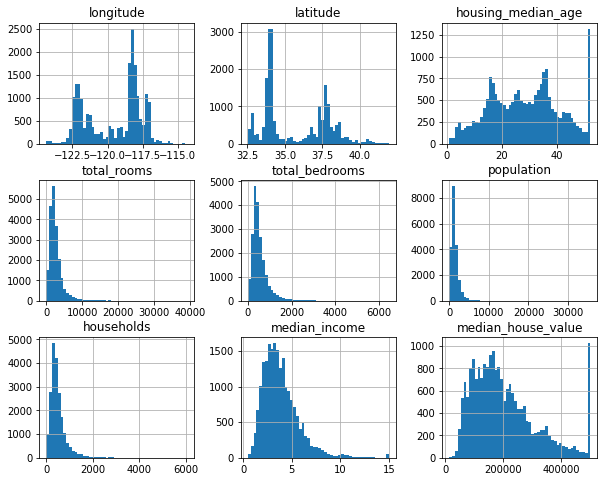

In [41]:
housing.hist(bins=50, figsize=(10, 8))
plt.show()

The next step is to split the data into **training** and **test** sets. Creating a **test** set is theoretically straightforward: select some instances at random, typically 20% of the dataset (or less if our dataset is very large), and set them aside:

`from sklearn.model_selection import train_test_split
 train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)`

However if we take a closer look at the histogram of median income. Most median income values cluster around 1.5 to 6, but some median income goes well beyond 6.

In [42]:
housing['median_income'].value_counts(bins = 15).sort_index()

(0.484, 1.467]       736
(1.467, 2.433]      3762
(2.433, 3.4]        5185
(3.4, 4.367]        4505
(4.367, 5.333]      2923
(5.333, 6.3]        1660
(6.3, 7.267]         815
(7.267, 8.233]       458
(8.233, 9.2]         215
(9.2, 10.167]        110
(10.167, 11.133]     124
(11.133, 12.1]        37
(12.1, 13.067]        32
(13.067, 14.033]      21
(14.033, 15.0]        57
Name: median_income, dtype: int64

It is important to have a sufficient number of instances in our dataset for each stratum, otherwise, the estimate of the importance of a stratum may be biased. This means that we should not have too many strata and that each stratum should be large enough:

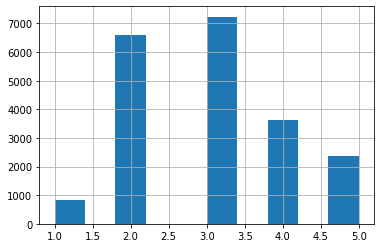

In [43]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()
plt.show()

In [44]:
housing['income_cat'].value_counts(bins = 5).sort_index()

(0.995, 1.8]     822
(1.8, 2.6]      6581
(2.6, 3.4]      7236
(3.4, 4.2]      3639
(4.2, 5.0]      2362
Name: income_cat, dtype: int64

### Stratified Sampling on Dataset

Now the next step is to perform some stratified sampling on the dataset. We will perform stratified sampling based on **income category**. For this we can use the `StratifiedShuffleSplit` class of **Scikit-Learn**:

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]): # Stratification is done based on "income_cat"
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
# print(strat_test_set['income_cat'].value_counts().sort_index())
# print(strat_train_set['income_cat'].value_counts().sort_index())

In [11]:
# print(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

Now we need to remove the `income_cat` attribute added by us to get the data back to its form:

In [12]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
    
housing = strat_train_set.copy()

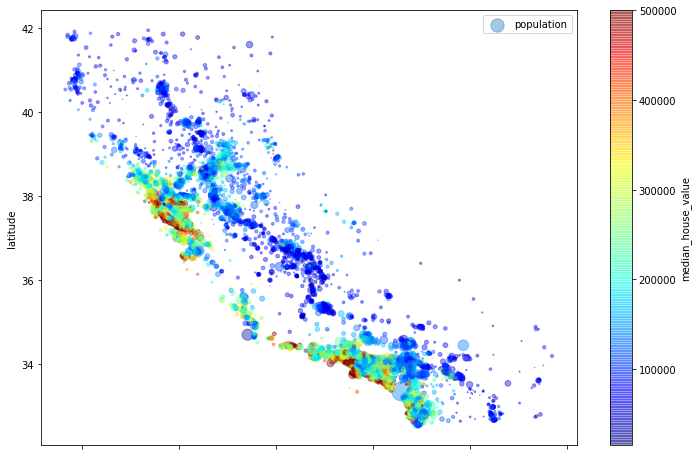

In [13]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
             s=housing['population']/100,label='population',figsize=(12, 8), 
             c='median_house_value', cmap=plt.get_cmap('jet'),colorbar=True)
plt.legend()
plt.show()

The graph shows, house prices in **California** where `red` is expensive, `blue` is cheap, larger circles indicate areas with a larger population.

### Finding Correlations

Since the dataset is not too large, we can easily calculate the standard correlation coefficient between each pair of attributes using the `corr()` method:

In [14]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Correlation ranges are between `-1` and `1`. When it is close to `1` it means that there is a **positive correlation** and when it is close to `-1` it means that there is a **negative correlation**. When it is close to `0`, it means that there is no **linear correlation**.

Another way to check the correlation between attributes is to use the pandas `scatter_matrix()` function, which plots each **numeric attribute** against every other **numeric attribute**:

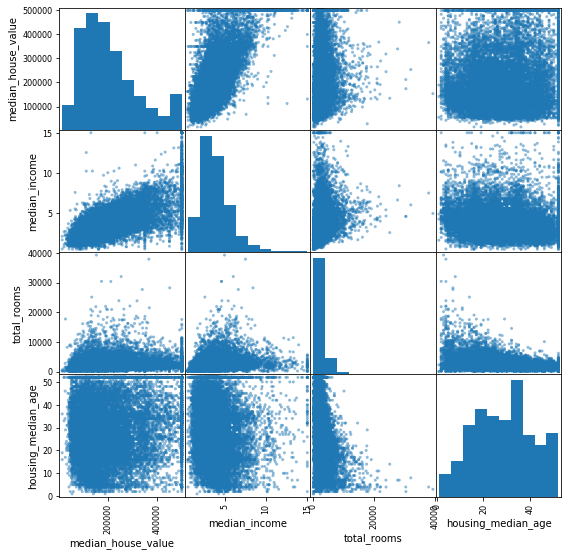

In [15]:
from pandas.plotting import scatter_matrix

scatter_matrix(housing[['median_house_value','median_income','total_rooms',
                        'housing_median_age']],
               figsize = (9,9))
plt.show()

Now let’s look at the correlation matrix again by adding three new columns to the dataset; `rooms per household`, `bedrooms per room` and `population per household`:

In [16]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [17]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Data Preparation

Now, this is the most important step before a train a machine learning model for house price prediction. Now let’s perform all the necessary data transformations:

In [18]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

housing_num = housing.drop("ocean_proximity", axis=1)

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room] # np.c_, concatenate along column axis (axis = 1)
        else:
            return np.c_[X, rooms_per_household, population_per_household]

As we can see, there are many data transformation steps that need to be performed in the correct order. Fortunately, **Scikit-Learn** provides the `Pipeline` class to help with such sequences of transformations. Here is a small pipeline for numeric attributes:

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([ 
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [21]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) # it will return a columns name of DataFrame
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

### Linear Regression for House Price Prediction

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

data = housing.iloc[:5]
labels = housing_labels.iloc[:5]

data_preparation = full_pipeline.transform(data)
print("Predictions: ", lin_reg.predict(data_preparation))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


### Summary codes

In [57]:
# housing = pd.read_csv("housing.csv")
# housing.head()

In [58]:
# housing['income_cat'] = pd.cut(housing['median_income'],
#                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
#                                labels=[1, 2, 3, 4, 5])

In [59]:
# from sklearn.model_selection import StratifiedShuffleSplit

# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# for train_index, test_index in split.split(housing, housing["income_cat"]):
#     strat_train_set = housing.loc[train_index]
#     strat_test_set = housing.loc[test_index]

In [ ]:
# for set_ in (strat_train_set, strat_test_set):
#     set_.drop('income_cat', axis=1, inplace=True)

In [60]:
# housing = strat_train_set.drop("median_house_value", axis=1)
# housing_labels = strat_train_set["median_house_value"].copy()

# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

# housing_num = housing.drop("ocean_proximity", axis=1)

In [61]:
# from sklearn.base import BaseEstimator, TransformerMixin

# rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
#         self.add_bedrooms_per_room = add_bedrooms_per_room
#     def fit(self, X, y=None):
#         return self  # nothing else to do
#     def transform(self, X):
#         rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
#         population_per_household = X[:, population_ix] / X[:, households_ix]
#         if self.add_bedrooms_per_room:
#             bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
#             return np.c_[X, rooms_per_household, population_per_household,
#                          bedrooms_per_room]
#         else:
#             return np.c_[X, rooms_per_household, population_per_household]

In [62]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer

# num_pipeline = Pipeline([ 
#     ('imputer',SimpleImputer(strategy="median")),
#     ('attribs_adder', CombinedAttributesAdder()),
#     ('std_scaler', StandardScaler()),
#     ])

# housing_num_tr = num_pipeline.fit_transform(housing_num)

In [63]:
# from sklearn.compose import ColumnTransformer

# num_attribs = list(housing_num) # it will return a columns name of DataFrame
# cat_attribs = ["ocean_proximity"]

# full_pipeline = ColumnTransformer([
#     ("num", num_pipeline, num_attribs),
#     ("cat", OneHotEncoder(), cat_attribs),
#     ])

# housing_prepared = full_pipeline.fit_transform(housing)

In [64]:
# from sklearn.linear_model import LinearRegression

# lin_reg = LinearRegression()
# lin_reg.fit(housing_prepared, housing_labels)

# data = housing.iloc[:5]
# labels = housing_labels.iloc[:5]

# data_preparation = full_pipeline.transform(data)
# print("Predictions: ", lin_reg.predict(data_preparation))